In [1]:
import pandas as pd #used for data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np #used for linear algebra
from numpy import array
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
sns.set()
from collections import Counter

from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap

# To create interactive plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, LSTM, Dropout,BatchNormalization
from keras.utils.np_utils import to_categorical

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


import tensorflow as tf

import logging
tf.get_logger().setLevel(logging.ERROR)



# FINAL VERSION ?

In [2]:
training_data = pd.read_csv('Processed Data/train.csv')
testing_data = pd.read_csv('Processed Data/test.csv')

#Checking for null values
print("Training Data: {}".format(training_data.shape))
print("Null values present in training data: {}".format(training_data.isnull().values.any()))

print("Testing Data: {}".format(testing_data.shape))
print("Null values present in testing data: {}".format(testing_data.isnull().values.any()))

Training Data: (300, 281)
Null values present in training data: False
Testing Data: (75, 281)
Null values present in testing data: False


In [3]:
# Combine boths dataframes
training_data['Data'] = 'Train'
testing_data['Data'] = 'Test'
all_data = pd.concat([training_data, testing_data], axis=0).reset_index(drop=True)
all_data['Environment'] = '#' + all_data['Environment'].astype(str)

# Create label
label = all_data.pop('Activity')

pd.DataFrame.from_dict(Counter([col.split('_')[0].split('(')[0] for col in all_data.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAccJerk,27
fBodyGyro,27
fBodyAcc,27
tBodyAcc,21
tGravityAcc,21
tBodyAccJerk,21
tBodyGyroJerk,21
tGravityGyro,21
tBodyGyro,21
fBodyAccMag,9


In [4]:
# Get X and y for training data
y_train = training_data['Activity']
X_train = training_data.drop(columns = ['Activity', 'Environment'])

# Get X and y for testing data
y_test = testing_data['Activity']
X_test = testing_data.drop(columns = ['Activity', 'Environment'])

In [5]:
# Plotting data
label_counts = label.value_counts()

# Get colors
n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Create plot
data = go.Bar(x = label_counts.index,
              y = label_counts,
              marker = dict(color = colors))



layout = go.Layout(title = 'Smartphone Activity Label Distribution',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'),
                   height = 400,
                   width = 900)

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

#fig.write_image("Plots/Activity Distribution.png")


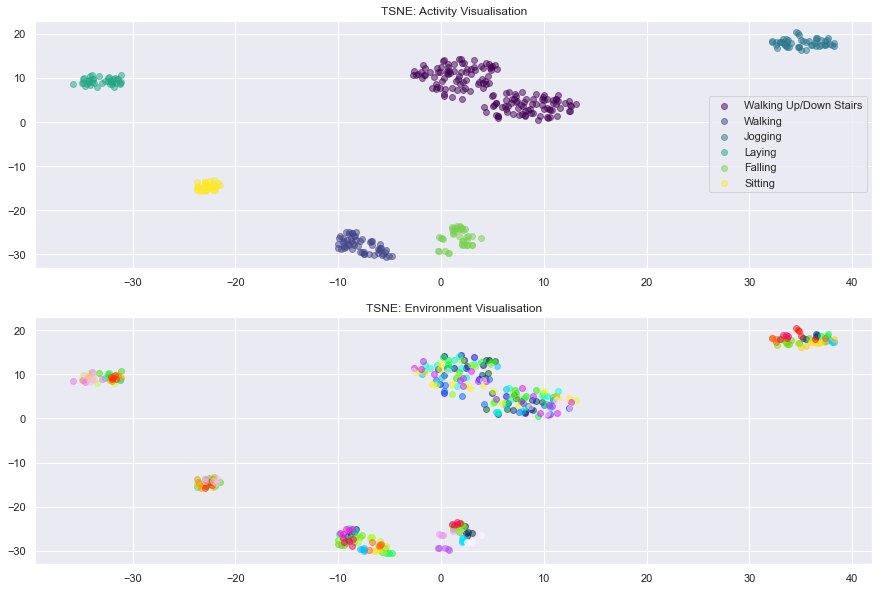

In [6]:
# Create datasets
tsne_data = all_data.copy()
data_data = tsne_data.pop('Data')
environment_data = tsne_data.pop('Environment')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)

# Create subplots
fig, axarr = plt.subplots(2, 1, figsize=(15,10))

### Plot Activities
# Get colors
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (label==group).values
    axarr[0].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[0].set_title('TSNE: Activity Visualisation')
axarr[0].legend(loc='center right', bbox_to_anchor=(1, 0.5))

### Plot Environment
# Get colors
n = environment_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each participant
for i, group in enumerate(environment_data.unique()):
    # Mask to separate sets
    mask = (environment_data==group).values
    axarr[1].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr[1].set_title('TSNE: Environment Visualisation')
#axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.savefig('Plots/TSNEs.png')

In [7]:
training_data = pd.read_csv('Processed Data/train.csv')
testing_data = pd.read_csv('Processed Data/test.csv')
target_names = [ 'Falling', 'Jogging', 'Laying','Sitting','Walking','Up/Down Stairs']


# SVM KNN NAIVE-BAYES 

In [8]:
def define_models(models=dict()):
    # nonlinear models
    models['knn'] = KNeighborsClassifier(n_neighbors=7)
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    print('Defined %d models' % len(models))
    return models

# evaluate a single model
def evaluate_model(trainX, trainy, testX, testy, model):
    # fit the model
    model.fit(trainX, trainy)
    # make predictions
    predictions = model.predict(testX)
    # evaluate predictions
    cm = confusion_matrix(testy, predictions)
    cr = classification_report(testy, predictions, target_names=target_names)
    accuracy = accuracy_score(testy, predictions)* 100.0
    precision = precision_score(testy,predictions,average='weighted')* 100.0
    recall = recall_score(testy, predictions,average='weighted')* 100.0

    return accuracy,precision,recall,cm,cr 

# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(trainX, trainy, testX, testy, models):
    aaccuracy = dict()
    precision = dict()
    recall = dict()
    cm = dict()
    cr=dict()
    for name, model in models.items():
        # evaluate the model
        aaccuracy[name],precision[name],recall[name],cm[name],cr[name] = evaluate_model(trainX, trainy, testX, testy, model)
        # show process
    return aaccuracy,precision,recall,cm,cr

# print and plot the results
def summarize_results(results,precision,recall,cm,cr,maximize=True):
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k,v) for k,v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g. for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    print()
    for name, score in mean_scores:
        print('Name: %s,\t Accuracy: %.3f,\t Precision: %.3f,\t Recall: %.3f\n' % (name, score,precision[name],recall[name]))
        
        print(cr[name])
        print()
        
        df_cm = pd.DataFrame(cm[name], index = target_names, columns =target_names)
        fig, ax = plt.subplots(figsize=(7,7))  
        heatmap = sns.heatmap(df_cm, annot=True, cmap='PuBu', ax= ax)
        heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45) 
        heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=45) 
        plt.xlabel("Predicted", fontsize=13)
        plt.ylabel("True", fontsize=13)
        fig.suptitle(name, fontsize=20)
        plt.show()
        #plt.savefig('Plots/'+ name +'_confusion_matrix.png')
        

In [9]:
def four_models(training_data, testing_data):
    # Get X and y for training data
    y_train = training_data['Activity']
    X_train = training_data.drop(columns = ['Activity', 'Environment'])

    # Get X and y for testing data
    y_test = testing_data['Activity']
    X_test = testing_data.drop(columns = ['Activity', 'Environment'])
    
    models = define_models()
    # evaluate models
    accuracy,precision,recall,cm,cr = evaluate_models(X_train, y_train, X_test, y_test, models)
    # summarize results
    summarize_results(accuracy,precision,recall,cm,cr)
    
    return accuracy
#FOUR_MODELS(training_data, testing_data)

Defined 3 models

Name: bayes,	 Accuracy: 92.000,	 Precision: 93.094,	 Recall: 92.000

                precision    recall  f1-score   support

       Falling       1.00      0.89      0.94         9
       Jogging       0.90      1.00      0.95         9
        Laying       1.00      0.92      0.96        12
       Sitting       0.75      1.00      0.86         3
       Walking       1.00      0.67      0.80        12
Up/Down Stairs       0.88      1.00      0.94        30

      accuracy                           0.92        75
     macro avg       0.92      0.91      0.91        75
  weighted avg       0.93      0.92      0.92        75




C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `z

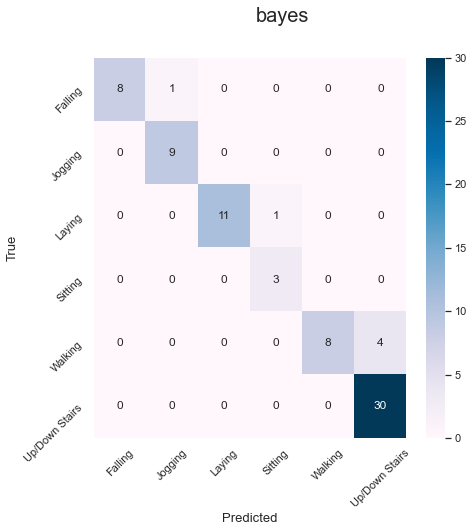

Name: knn,	 Accuracy: 88.000,	 Precision: 90.222,	 Recall: 88.000

                precision    recall  f1-score   support

       Falling       1.00      1.00      1.00         9
       Jogging       1.00      1.00      1.00         9
        Laying       0.89      0.67      0.76        12
       Sitting       0.33      0.67      0.44         3
       Walking       0.83      0.83      0.83        12
Up/Down Stairs       0.93      0.93      0.93        30

      accuracy                           0.88        75
     macro avg       0.83      0.85      0.83        75
  weighted avg       0.90      0.88      0.89        75




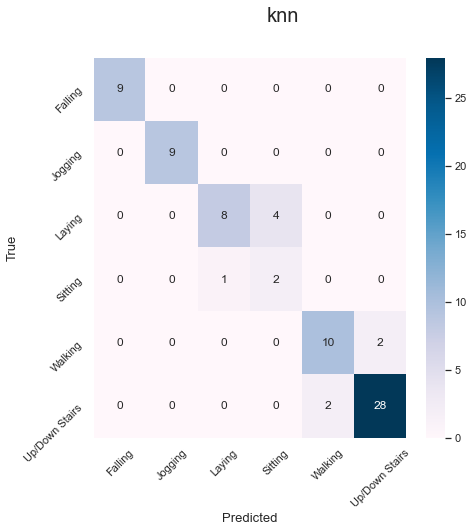

Name: svm,	 Accuracy: 73.333,	 Precision: 62.333,	 Recall: 73.333

                precision    recall  f1-score   support

       Falling       1.00      0.67      0.80         9
       Jogging       1.00      1.00      1.00         9
        Laying       0.83      0.83      0.83        12
       Sitting       0.00      0.00      0.00         3
       Walking       0.00      0.00      0.00        12
Up/Down Stairs       0.62      1.00      0.77        30

      accuracy                           0.73        75
     macro avg       0.58      0.58      0.57        75
  weighted avg       0.62      0.73      0.66        75




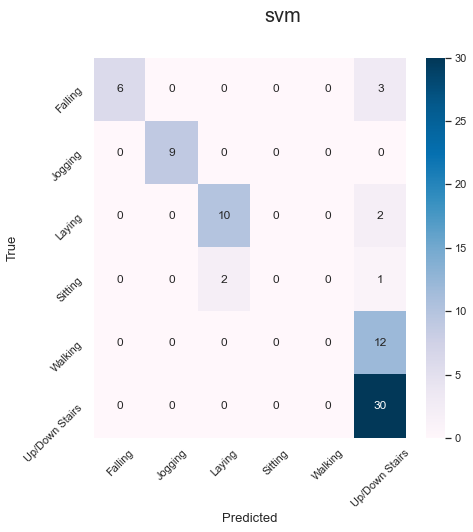

In [10]:
models_accuracy = four_models(training_data, testing_data)


# LSTM

3/3 [==============================] - 0s 1ms/step - loss: 0.4197 - accuracy: 1.0000
LSTM: 85.33333333333334%
                precision    recall  f1-score   support

       Falling       0.56      1.00      0.72         9
       Jogging       1.00      1.00      1.00         9
        Laying       1.00      1.00      1.00        12
       Sitting       0.00      0.00      0.00         3
       Walking       1.00      0.67      0.80        12
Up/Down Stairs       1.00      1.00      1.00        30

      accuracy                           0.91        75
     macro avg       0.76      0.78      0.75        75
  weighted avg       0.91      0.91      0.89        75



C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



3/3 [==============================] - 0s 2ms/step - loss: 0.4117 - accuracy: 1.0000
LSTM: 85.33333333333334%
                precision    recall  f1-score   support

       Falling       0.47      1.00      0.64         9
       Jogging       1.00      1.00      1.00         9
        Laying       1.00      0.83      0.91        12
       Sitting       1.00      1.00      1.00         3
       Walking       1.00      0.33      0.50        12
Up/Down Stairs       1.00      1.00      1.00        30

      accuracy                           0.87        75
     macro avg       0.91      0.86      0.84        75
  weighted avg       0.94      0.87      0.86        75

3/3 [==============================] - 0s 1ms/step - loss: 0.5068 - accuracy: 1.0000
LSTM: 65.33333333333333%
                precision    recall  f1-score   support

       Falling       0.26      1.00      0.42         9
       Jogging       1.00      1.00      1.00         9
        Laying       0.00      0.00      0.00   

C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



3/3 [==============================] - 0s 1ms/step - loss: 0.4599 - accuracy: 1.0000
LSTM: 77.33333333333333%
                precision    recall  f1-score   support

       Falling       0.41      1.00      0.58         9
       Jogging       1.00      1.00      1.00         9
        Laying       1.00      1.00      1.00        12
       Sitting       0.00      0.00      0.00         3
       Walking       1.00      0.17      0.29        12
Up/Down Stairs       1.00      1.00      1.00        30

      accuracy                           0.83        75
     macro avg       0.73      0.69      0.64        75
  weighted avg       0.89      0.83      0.80        75



C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



3/3 [==============================] - 0s 1ms/step - loss: 0.3965 - accuracy: 1.0000
LSTM: 82.66666666666667%
                precision    recall  f1-score   support

       Falling       0.43      1.00      0.60         9
       Jogging       1.00      1.00      1.00         9
        Laying       1.00      1.00      1.00        12
       Sitting       1.00      0.33      0.50         3
       Walking       1.00      0.17      0.29        12
Up/Down Stairs       1.00      1.00      1.00        30

      accuracy                           0.84        75
     macro avg       0.90      0.75      0.73        75
  weighted avg       0.93      0.84      0.82        75

3/3 [==============================] - 0s 1ms/step - loss: 0.4076 - accuracy: 1.0000
LSTM: 82.66666666666667%
                precision    recall  f1-score   support

       Falling       0.45      1.00      0.62         9
       Jogging       1.00      1.00      1.00         9
        Laying       1.00      1.00      1.00   

C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



3/3 [==============================] - 0s 2ms/step - loss: 0.4269 - accuracy: 1.0000
LSTM: 86.66666666666667%
                precision    recall  f1-score   support

       Falling       0.50      1.00      0.67         9
       Jogging       1.00      1.00      1.00         9
        Laying       1.00      1.00      1.00        12
       Sitting       1.00      1.00      1.00         3
       Walking       1.00      0.25      0.40        12
Up/Down Stairs       1.00      1.00      1.00        30

      accuracy                           0.88        75
     macro avg       0.92      0.88      0.84        75
  weighted avg       0.94      0.88      0.86        75

3/3 [==============================] - 0s 1ms/step - loss: 0.4760 - accuracy: 1.0000
LSTM: 72.0%
                precision    recall  f1-score   support

       Falling       0.33      1.00      0.50         9
       Jogging       1.00      1.00      1.00         9
        Laying       1.00      0.42      0.59        12
     

C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\PC\.conda\envs\GAPT\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



LSTM Best Result: 86.6667%
LSTM Average Result: 77.46667%


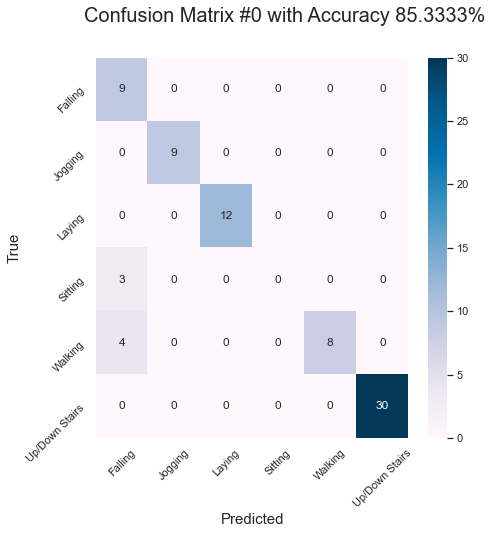

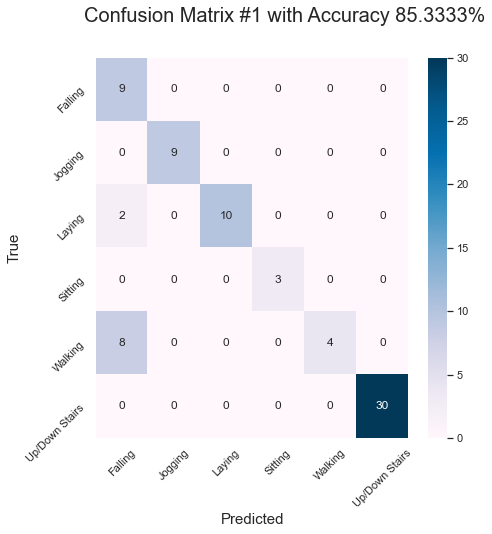

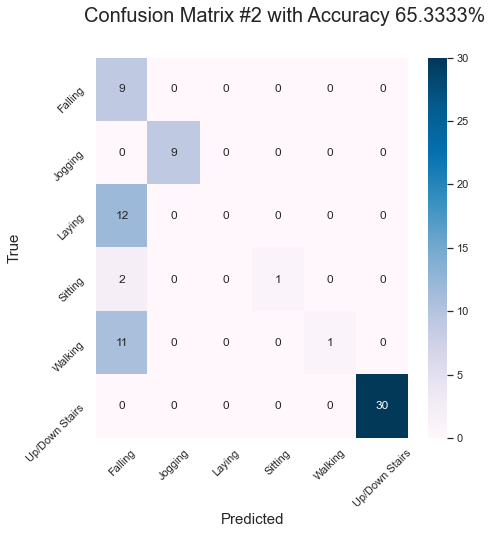

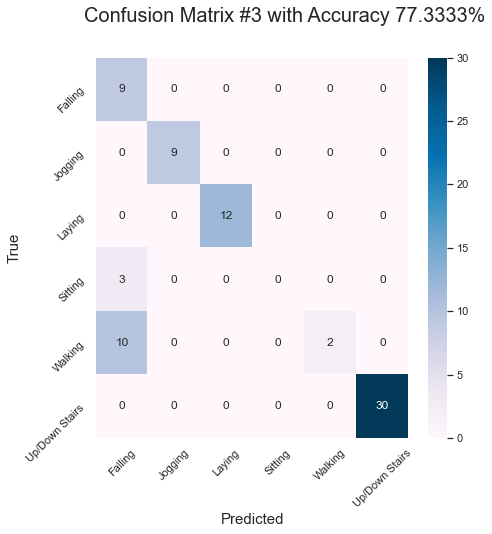

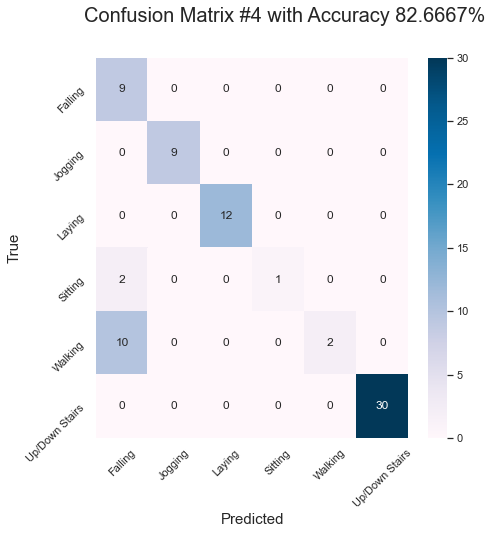

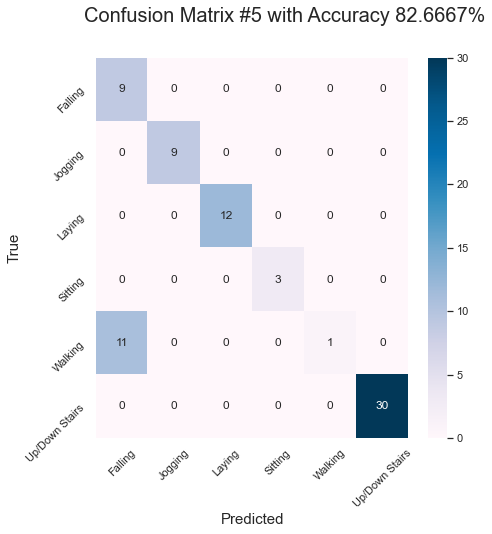

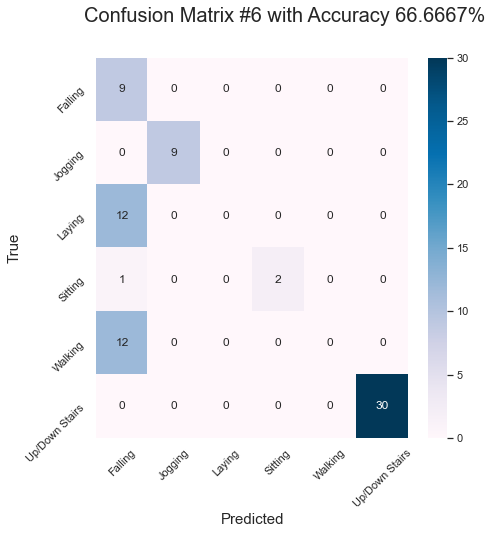

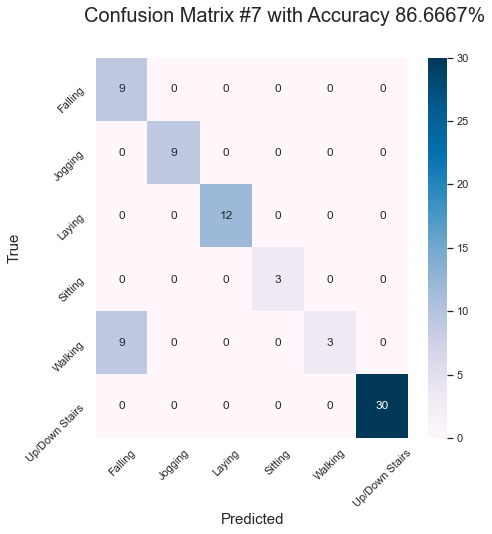

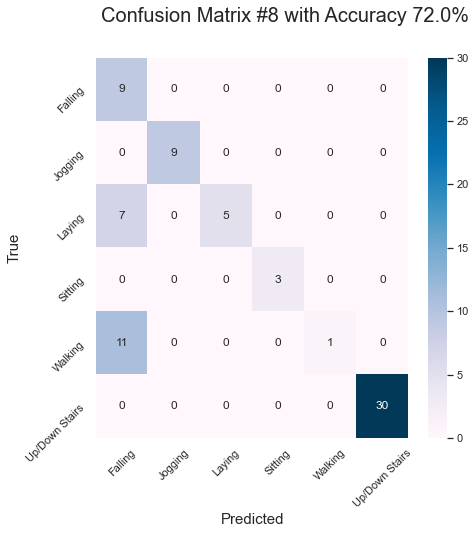

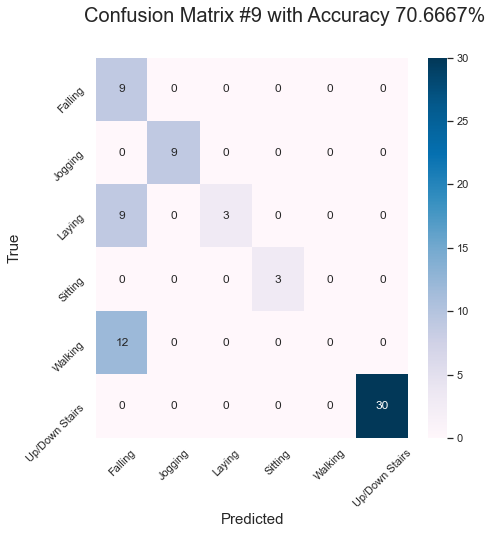

In [11]:
def LSTM_(training_data,testing_data):

    training_data['Activity']=training_data['Activity'].astype('category').cat.codes
    testing_data['Activity']=testing_data['Activity'].astype('category').cat.codes
        
    y_tr = training_data['Activity']
    y_te = testing_data['Activity']
    
    y_train = keras.utils.to_categorical(y_tr)
    y_test = keras.utils.to_categorical(y_te)

    X_train = training_data.drop(columns = ['Activity', 'Environment'])
    X_test =  testing_data.drop(columns = ['Activity', 'Environment'])

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    
    x_train = X_train.reshape(300,1,279)
    x_test = X_test.reshape(75,1,279)
    
    model = Sequential()
    model.add(LSTM( 128, activation = 'relu', input_shape=(x_train.shape[1:]), return_sequences = True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(LSTM(64,input_shape=(x_train.shape[1:]),activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(6,activation = 'softmax'))

    opt = tf.keras.optimizers.Adam(lr=1e-3,decay=1e-5)

    model.compile(loss = 'categorical_crossentropy',optimizer = opt, metrics = ['accuracy'])
    
    history = model.fit(x_train, y_train, epochs = 25, batch_size=64,verbose = None)

    score = model.evaluate(x_test, y_test)
    y_pred = model.predict(x_test)
    

    #print(cm)
    return history, y_test,y_pred

results = []

for i in range(10):
    history, y_test, y_pred = LSTM_(training_data,testing_data)
    predictionLSTM = (y_pred > 0.5)
    print('LSTM: {}%'.format(accuracy_score(y_test, predictionLSTM)*100))
    predictionLSTM = round((accuracy_score(y_test, predictionLSTM)*100),4) 
    results.append(predictionLSTM)
    p = (y_pred > 0.5)
    y_test_class=np.argmax(y_test,axis=1)
    y_pred_class=np.argmax(p,axis=1)
        
    print(classification_report(y_test_class,y_pred_class, target_names=target_names))
    cm=confusion_matrix(y_test_class,y_pred_class)
    
    df_cm = pd.DataFrame(cm, index = target_names, columns = target_names)
    fig, ax = plt.subplots(figsize=(7,7))  
    heatmap = sns.heatmap(df_cm, annot=True, cmap='PuBu', ax= ax)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45) 
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=45) 
    plt.xlabel("Predicted", fontsize=15)
    plt.ylabel("True", fontsize=15)
    fig.suptitle('Confusion Matrix #{} with Accuracy {}%'.format(i,predictionLSTM), fontsize=20)
    plt.savefig('Plots/LSTM/lstm_'+str(i)+'_'+str(predictionLSTM)+'_confusion_matrix.png')
    #plt.show()
    
LSTM_Best = max(results)
LSTM_Average = sum(results)/len(results)
    
print('LSTM Best Result: {}%'.format(LSTM_Best))
print('LSTM Average Result: {}%'.format(LSTM_Average))
#plot_accuracy_loss(history)



In [12]:
models = [("SVM",models_accuracy['svm']),("KNN",models_accuracy['knn']),
          ("Bayes",models_accuracy['bayes']),("LSTM",LSTM_Best)]
for i in models:
    print("{}".format(i[0]), "\t\t {}%".format(round(i[1],2)))
max = 0.0
min = 100.0
best =""
worst = ""
for i in models:
    value = i[1]
    if i[1]> max :
        best = i[0]
        max = i[1]
    if i[1]<min :
        worst = i[0]
        min = i[1]
print("--------------------------")        
print("Best Model: \t",best)
print("Worst Model:\t",worst)
print("--------------------------")    

SVM 		 73.33%
KNN 		 88.0%
Bayes 		 92.0%
LSTM 		 86.67%
--------------------------
Best Model: 	 Bayes
Worst Model:	 SVM
--------------------------
